# Convolutional Bayesian Neural Network

In [162]:
import jax
import blackjax
import distrax
import optax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from flax.traing import train_step
from tqdm.notebook import tqdm
from torchvision.datasets import MNIST
from jax.flatten_util import ravel_pytree
from blackjax.sgmcmc.gradients import grad_estimator
from sklearn.metrics import confusion_matrix

In [10]:
%config InlineBackend.figure_format = "retina"
DIR_MNIST = "/tmp/mnist"

In [38]:
class CNN(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1)) 
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)

    return x

In [39]:
def logpdf(params, images, categories, model):
    logits = model.apply(params, images)
    flat_params, _ = ravel_pytree(params)
    log_prior = distrax.Normal(0.0, 1.0).log_prob(flat_params).sum()
    log_likelihood = distrax.Multinomial(10, logits=logits).log_prob(categories).sum()
 
    return log_prior + log_likelihood

In [40]:
mnist = MNIST(DIR_MNIST, train=True)

In [170]:
num_samples = 2000

X_train = jnp.array(mnist.data)
X_train = jnp.round(X_train / 255)

y_train = jnp.array(mnist.targets)


X_train = X_train[:num_samples]
y_train = y_train[:num_samples]
y_train_ohe = jax.nn.one_hot(y_train, 10)

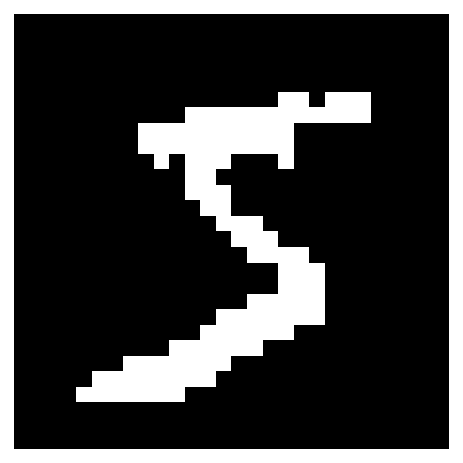

In [171]:
plt.imshow(X_train[0], cmap="bone")
plt.axis("off");

In [182]:
def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def sgd_train_step(state, X_batch, y_batch, loss_fn):
    """
    Apply jax.jit after defining partial function
    with loss_fn specified, i.e., 
    part_loss_fn = partial(loss_fn, X=X_batch)
    part_sgd_train_step = partial(sgd_train_step, loss_fn=part_loss_fn)
    part_sgd_train_step = jax.jit(part_sgd_train_step)
    
    Parameters
    ----------
    loss_fn: function
        Function taking: params, X, model
    """
    loss_fn = partial(loss_fn, X=X_batch, y=y_batch)
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return loss, new_state


def train_epoch(key, state, X, y, batch_size, epoch, model, train_step):
    num_samples = len(X)
    batch_ixs = get_batch_train_ixs(key, num_samples, batch_size)
    total_loss = 0
    for batch_ix in batch_ixs:
        X_batch = X[batch_ix, ...]
        y_batch = y[batch_ix, ...]
        loss, state = train_step(state, X_batch, y_batch)
        total_loss += loss
    
    return total_loss.item(), state

In [183]:
def loss_fn(params, X, y, model):
    logits = model.apply(params, X[..., None])
    loss = optax.softmax_cross_entropy(logits, y)
    
    return loss.mean()

In [184]:
key = jax.random.PRNGKey(314)
key_params_init, key_train, key = jax.random.split(key, 3)

In [185]:
alpha = 5e-4
model = CNN()
tx = optax.adam(learning_rate=alpha)
batch_size = 200
_, *dim_observed = X_train.shape
num_channels = 1
params_init = model.init(key_params_init, jnp.ones((batch_size, *dim_observed, num_channels)))

In [186]:
loss_fn(params_init, X_train[:5], y_train_ohe[:5], model)
loss_fn_part = partial(loss_fn, model=model)

state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=tx
)

In [187]:
train_step = partial(sgd_train_step, loss_fn=loss_fn_part)

In [ ]:
batch_size = 1000
n_epochs = 500
keys_train = jax.random.split(key_train, n_epochs)

loss_hist = []
params_hist = []
pbar = tqdm(enumerate(keys_train), total=len(keys_train))
for e, key_train in pbar:
    loss, state = train_epoch(key_train, state, X_train, y_train_ohe, batch_size, e, model, train_step)
    loss_hist.append(loss)
    pbar.set_description(f"{loss=:0.4e}")
    if e % 100 == 0:
        params_hist.append(state.params)

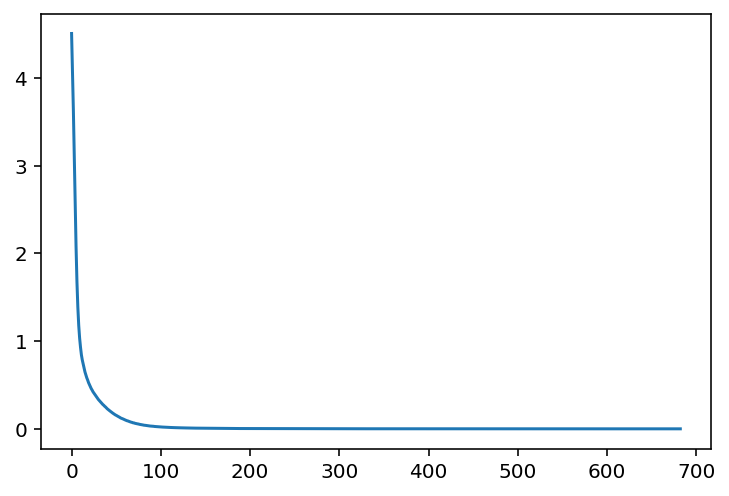

In [189]:
plt.plot(loss_hist)

## Testing model

In [190]:
mnist_test = MNIST(DIR_MNIST, train=False)

X_test = jnp.array(mnist_test.data)
X_test = jnp.round(X_test / 255)

y_test = jnp.array(mnist_test.targets)
y_test_ohe = jax.nn.one_hot(y_test, 10)

In [191]:
yhat_test = model.apply(state.params, X_test[..., None]).argmax(axis=1)

In [192]:
confusion_matrix(y_test, yhat_test)

array([[ 958,    0,    3,    1,    2,    0,   12,    1,    1,    2],
       [   1, 1121,    4,    1,    0,    1,    3,    1,    2,    1],
       [   6,    1,  978,   12,    6,    1,    4,    7,   15,    2],
       [   0,    0,   12,  962,    0,   13,    0,   10,    9,    4],
       [   1,    3,    2,    0,  939,    0,    4,    1,    3,   29],
       [   4,    2,    0,   10,    1,  854,    8,    1,    6,    6],
       [  11,    3,    4,    0,    5,    9,  919,    0,    7,    0],
       [   0,    4,   22,    9,    4,    0,    0,  971,    3,   15],
       [   9,    2,    9,   14,   13,    8,    6,    8,  891,   14],
       [   3,    5,    4,    5,    6,   10,    0,   12,    2,  962]])

In [194]:
(y_test == yhat_test).mean()

DeviceArray(0.95549995, dtype=float32)

## SGLD

In [163]:
def model_log_prior(params, model):
    flatten_params, _ = ravel_pytree(params)
    log_prior = distrax.Normal(0.0, 1.0).log_prob(flatten_params).sum()
    return log_prior


def model_log_likelihood(params, data, model):
    X, y = data
    logits = model.apply(params, X)
    log_likelihood = distrax.Multinomial(10, logits=logits).log_prob(y).sum()
    return log_likelihood


In [164]:
part_log_likelihood = partial(model_log_likelihood, model=model)
part_log_prior = partial(model_log_prior, model=model)

In [165]:
data_size = len(y_train)
step_size = 1e-5

num_warmup = 200
num_samples = 800



# Build the SGLD kernel
schedule_fn = lambda _: step_size  # constant step size
grad_fn = grad_estimator(part_log_prior, part_log_likelihood, data_size)
sgld = blackjax.sgld(grad_fn, schedule_fn)

In [ ]:
def sgld_train_step(state, X_batch, y_batch, loss_fn):
    """
    Apply jax.jit after defining partial function
    with loss_fn specified, i.e., 
    part_loss_fn = partial(loss_fn, X=X_batch)
    part_sgd_train_step = partial(sgd_train_step, loss_fn=part_loss_fn)
    part_sgd_train_step = jax.jit(part_sgd_train_step)
    
    Parameters
    ----------
    loss_fn: function
        Function taking: params, X, model
    """
    loss_fn = partial(loss_fn, X=X_batch, y=y_batch)
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return loss, new_state


def train_epoch(key, state, X, y, batch_size, epoch, model, train_step):
    num_samples = len(X)
    batch_ixs = get_batch_train_ixs(key, num_samples, batch_size)
    total_loss = 0
    for batch_ix in batch_ixs:
        X_batch = X[batch_ix, ...]
        y_batch = y[batch_ix, ...]
        loss, state = sgd_train_step(state, X_batch, y_batch)
        total_loss += loss
    
    return total_loss.item(), state